## 📚 **What This Agent Does - In Simple Terms:**
```
┌─────────────────────────────────────────────────────────┐
│                    USER ASKS QUESTION                    │
└──────────────────┬──────────────────────────────────────┘
                   │
                   ▼
┌─────────────────────────────────────────────────────────┐
│  SUPERVISOR: "Is this about USA or something else?"     │
└──────────────────┬──────────────────────────────────────┘
                   │
                   ▼
┌─────────────────────────────────────────────────────────┐
│  ROUTER: "Which expert should answer this?"             │
└────┬────────────────────────────────────────┬───────────┘
     │                                        │
     ▼                                        ▼
┌─────────────┐                        ┌──────────────┐
│  About USA? │                        │  Other topic?│
│  Use RAG    │                        │  Use LLM     │
│  (Docs)     │                        │  (General)   │
└─────┬───────┘                        └──────┬───────┘
      │                                       │
      └───────────────┬───────────────────────┘
                      ▼
              ┌──────────────┐
              │    ANSWER    │
              └──────────────┘

In [1]:
# ============================================
# COMPLETE RAG AGENT WITH LANGGRAPH
# A beginner-friendly guide to building an AI agent
# that routes questions to either a knowledge base (RAG)
# or general LLM based on topic classification
# ============================================

In [2]:
# Import Environment Variables
import dotenv
dotenv.load_dotenv()

True


### STEP 1: IMPORT ALL NECESSARY LIBRARIES

In [3]:
# operator: Used for message accumulation in state
import operator

# typing: For type hints (helps with code clarity)
from typing import Annotated, Sequence, TypedDict

# pydantic: For structured data validation
from pydantic import BaseModel, Field

# LangChain components for prompts and parsing
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.output_parsers import PydanticOutputParser

# LangChain message types (important for conversation tracking)
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

# LangChain runnable for chaining operations
from langchain_core.runnables import RunnablePassthrough

# LangGraph for building the agent workflow
from langgraph.graph import StateGraph, END


### STEP 2: SET UP THE LLM (LANGUAGE MODEL)


In [4]:
from langchain_groq import ChatGroq

# Initialize the language model
# This is the "brain" that will answer questions

model = ChatGroq(
    model="llama-3.3-70b-versatile",  # Use actual Groq model
    #api_key="your-groq-api-key-here",  # Get from https://console.groq.com
    temperature=0.7
)

In [5]:
# Test the model (optional)
response = model.invoke("Hello")
print(response.content)  # Should print a greeting

Hello. How can I help you today?


### STEP 3: SET UP EMBEDDINGS MODEL

In [6]:
from langchain_huggingface import HuggingFaceEmbeddings

# Embeddings convert text into numerical vectors
# These vectors help us find similar documents
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: BAAI/bge-small-en
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [7]:

# Test embeddings (optional)
vector = embeddings.embed_query("hello")
print(len(vector))  # Should print 384 (vector dimension)

384


### STEP 4: LOAD AND PREPARE DOCUMENTS

In [8]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

STEP 4.1: Load documents from a folder

In [9]:
# DirectoryLoader: Loads all .txt files from a directory
loader = DirectoryLoader(
    "D:\\2026\\Krish Naik\\Agentic AI My Practice\\Langgraph_Intro",  # Your path
    glob="./*.txt",              # Only load .txt files
    loader_cls=TextLoader,       # Use TextLoader for text files
    loader_kwargs={'encoding': 'utf-8'}  # ✅ ADD THIS LINE
)

In [10]:
docs = loader.load()  # This loads all documents into memory

In [11]:
docs[0]  # Print the first document to verify it loaded correctly

Document(metadata={'source': 'D:\\2026\\Krish Naik\\Agentic AI My Practice\\Langgraph_Intro\\usa.txt'}, page_content="🇺🇸 Overview of the U.S. Economy\nThe United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.\n\nU.S. GDP – Size, Composition, and Global Share\nAs of 2024, the United States’ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of the global economy. It ranks #1 in the

STEP 4.2: Split documents into smaller chunks

In [12]:
# Why? LLMs have token limits, and smaller chunks improve retrieval accuracy
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,      # Each chunk will be ~200 characters
    chunk_overlap=50     # 50 character overlap between chunks (prevents info loss)
)

In [13]:
new_docs = text_splitter.split_documents(documents=docs)

In [14]:
new_docs[0]  # Print the first chunk to verify splitting worked

Document(metadata={'source': 'D:\\2026\\Krish Naik\\Agentic AI My Practice\\Langgraph_Intro\\usa.txt'}, page_content='🇺🇸 Overview of the U.S. Economy')

STEP 4.3: Create a vector database

In [15]:
# This stores document chunks as vectors for fast similarity search
db = Chroma.from_documents(
    new_docs,      # Our split documents
    embeddings     # Embedding model to convert text to vectors
)

STEP 4.4: Create a retriever

In [16]:
# The retriever finds the most relevant document chunks for a query
retriever = db.as_retriever(
    search_kwargs={"k": 3}  # Return top 3 most relevant chunks
)

In [17]:
# Test retriever (optional)
results = retriever.invoke("What is USA's GDP?")
print(results)  # Should show relevant document chunks

[Document(metadata={'source': 'D:\\2026\\Krish Naik\\Agentic AI My Practice\\Langgraph_Intro\\usa.txt'}, page_content='U.S. GDP – Size, Composition, and Global Share'), Document(metadata={'source': 'D:\\2026\\Krish Naik\\Agentic AI My Practice\\Langgraph_Intro\\usa.txt'}, page_content='🇺🇸 Overview of the U.S. Economy'), Document(metadata={'source': 'D:\\2026\\Krish Naik\\Agentic AI My Practice\\Langgraph_Intro\\usa.txt'}, page_content='As of 2024, the United States’ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of the global economy. It ranks #1 in the world by nominal GDP, far ahead of')]


### STEP 5: DEFINE STRUCTURED OUTPUT FORMAT

In [18]:
# We want the LLM to classify questions in a structured way
# Pydantic helps us enforce this structure

class TopicSelectionParser(BaseModel):
    """
    This class defines what the classification output should look like
    
    Example output:
    {
        "Topic": "USA",
        "Reasoning": "The question asks about US GDP"
    }
    """
    Topic: str = Field(
        description="Selected topic: either 'USA' or 'Not Related'"
    )
    Reasoning: str = Field(
        description="Explanation for why this topic was chosen"
    )

In [19]:
# Create a parser that will convert LLM output to this structure
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)


In [20]:
# Test the parser with a sample LLM output (optional)
sample_output = """{
    "Topic": "USA",
    "Reasoning": "The question asks about US GDP"
}"""
try:
    parsed_output = parser.parse(sample_output)
    print("Parsed Output:", parsed_output)
except Exception as e:
    print("Error parsing sample output:", e)

Parsed Output: Topic='USA' Reasoning='The question asks about US GDP'


In [21]:
# See what instructions the parser gives to the LLM (optional)
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"description": "This class defines what the classification output should look like\n\nExample output:\n{\n    \"Topic\": \"USA\",\n    \"Reasoning\": \"The question asks about US GDP\"\n}", "properties": {"Topic": {"description": "Selected topic: either 'USA' or 'Not Related'", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Explanation for why this topic was chosen", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
```


#### STEP 6: DEFINE THE AGENT STATE

In [22]:
class AgentState(TypedDict):
    """
    The "state" is like the agent's memory
    It flows through all nodes in the graph
    
    messages: A list that stores all messages in the conversation
              - Starts with the user's question (HumanMessage)
              - Accumulates AI responses (AIMessage)
              - operator.add means new messages are APPENDED to the list
    
    Example state flow:
    1. Start: {"messages": [HumanMessage("What is GDP?")]}
    2. After supervisor: {"messages": [HumanMessage("What is GDP?"), AIMessage("USA")]}
    3. After RAG: {"messages": [HumanMessage("What is GDP?"), AIMessage("USA"), AIMessage("GDP is...")]}
    """
    messages: Annotated[Sequence[BaseMessage], operator.add]

### STEP 7: DEFINE HELPER FUNCTIONS

In [23]:
def extract_message_content(message):
    """
    Helper function to safely extract text content from a message
    
    Args:
        message: Can be a BaseMessage object or a string
    
    Returns:
        String content of the message
    
    Why needed? State messages can be strings or BaseMessage objects
    This function handles both cases
    """
    if isinstance(message, BaseMessage):
        return message.content  # Extract content from BaseMessage
    else:
        return str(message)     # Convert to string if not BaseMessage


In [24]:
def format_docs(docs):
    """
    Combines multiple document chunks into a single string
    
    Args:
        docs: List of Document objects from retriever
    
    Returns:
        Single string with all documents separated by newlines
    
    Why needed? The LLM needs context as a single string, not a list
    """
    return "\n\n".join(doc.page_content for doc in docs) # Combine all document chunks into one string with separation

### STEP 8: DEFINE NODE FUNCTIONS (THE AGENT'S ACTIONS)

NODE 1: SUPERVISOR (Classifier)

In [25]:
def supervisor(state: AgentState): # This node classifies the user's question
    """
    SUPERVISOR NODE: Classifies the user's question
    
    Purpose: Determine if the question is about USA or not
    
    Input: AgentState with user's question
    Output: AgentState with classification ("USA" or "Not Related")
    
    Flow:
    1. Extract user's question from state
    2. Ask LLM to classify it
    3. Return classification as AIMessage
    """
    
    print("\n" + "="*60) # Visual separator for clarity in output
    print("🔍 SUPERVISOR: Classifying the question...") 
    print("="*60) # Visual separator for clarity in output
    
    # Get the user's question (it's the last message in state)
    last_message = state["messages"][-1]
    question = extract_message_content(last_message)
    
    print(f"📝 Question: {question}")


     # Create a prompt that asks the LLM to classify the question
    template = """
    Your task is to classify the given user query into one of the following categories: 
    [USA, Not Related]
    
    - Choose "USA" if the question is about the United States, its economy, GDP, politics, etc.
    - Choose "Not Related" for any other topic
    
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    
    # Create the prompt template
    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={
            "format_instructions": parser.get_format_instructions()
        }
    )

    # Create a chain: prompt → model → parser
    # The "|" operator chains these operations together
    chain = prompt | model | parser
    
    # Run the chain to get classification
    response = chain.invoke({"question": question})
    
    print(f"✅ Classification: {response.Topic}")
    print(f"💭 Reasoning: {response.Reasoning}")
    
    # Return the classification as an AIMessage
    # This gets added to the state's message list
    return {"messages": [AIMessage(content=response.Topic)]}

NODE 2: RAG (Retrieval-Augmented Generation)

In [26]:
def rag_function(state: AgentState):
    """
    RAG NODE: Answers using documents from the knowledge base
    
    Purpose: Find relevant documents and use them to answer the question
    
    Input: AgentState with user's question
    Output: AgentState with answer based on retrieved documents
    
    Flow:
    1. Extract the original question
    2. Retrieve relevant documents from vector database
    3. Format documents as context
    4. Ask LLM to answer using this context
    5. Return answer as AIMessage
    """
    
    print("\n" + "="*60)
    print("📚 RAG: Searching knowledge base...")
    print("="*60)
    
    # Get the original question (first message in state)
    first_message = state["messages"][0] # The user's question is always the first message
    question = extract_message_content(first_message)
    
    print(f"📝 Question: {question}")
    
    # Create a prompt for answering with context
    prompt = PromptTemplate(
        template="""You are an assistant for question-answering tasks. 
        Use the following pieces of retrieved context to answer the question. 
        If you don't know the answer, just say that you don't know. 
        Use three sentences maximum and keep the answer concise.
        
        Question: {question} 
        Context: {context} 
        Answer:""",
        input_variables=['context', 'question']
    )
    
    # Create RAG chain:
    # 1. Retrieve docs and format them as context
    # 2. Pass context and question to prompt
    # 3. Send to model
    # 4. Parse output as string
    rag_chain = (
        {
            "context": retriever | format_docs,  # Retrieve and format docs
            "question": RunnablePassthrough()     # Pass question through
        }
        | prompt          # Fill the prompt template
        | model           # Send to LLM
        | StrOutputParser()  # Parse response as string
    )
    
    # Run the chain to get the answer
    result = rag_chain.invoke(question)
    
    print(f"✅ Answer (from documents): {result[:150]}...")
    
    # Return answer as AIMessage
    return {"messages": [AIMessage(content=result)]}


NODE 3: LLM (Direct LLM Call)

In [27]:
def llm_function(state: AgentState):
    """
    LLM NODE: Answers using the LLM's general knowledge
    
    Purpose: Answer questions that don't need the knowledge base
    
    Input: AgentState with user's question
    Output: AgentState with answer from LLM's training data
    
    Flow:
    1. Extract the original question
    2. Ask LLM to answer using its general knowledge
    3. Return answer as AIMessage
    """
    
    print("\n" + "="*60)
    print("🤖 LLM: Using general knowledge...")
    print("="*60)
    
    # Get the original question (first message in state)
    first_message = state["messages"][0]
    question = extract_message_content(first_message)
    
    print(f"📝 Question: {question}")
    
    # Create an enhanced query
    complete_query = (
        f"Answer the following question with your knowledge of the real world. "
        f"Question: {question}"
    )
    
    # Get response directly from LLM (no RAG)
    response = model.invoke(complete_query)
    
    print(f"✅ Answer (from general knowledge): {response.content[:150]}...")
    
    # The response is already an AIMessage, so return it directly
    return {"messages": [response]}

### STEP 9: DEFINE ROUTING LOGIC

In [28]:
def router(state: AgentState):
    """
    ROUTER: Decides which path to take (RAG or LLM)
    
    Purpose: Based on classification, route to appropriate node
    
    Input: AgentState with classification result
    Output: String indicating which node to go to next
    
    Logic:
    - If classification contains "USA" → go to RAG (use knowledge base)
    - Otherwise → go to LLM (use general knowledge)
    """
    
    print("\n" + "="*60)
    print("🔀 ROUTER: Deciding which path to take...")
    print("="*60)
    
    # Get the classification (last message)
    last_message = state["messages"][-1]
    classification = extract_message_content(last_message) # This should be "USA" or "Not Related"
    
    print(f"📋 Classification: {classification}")
    
    # Decide which path to take
    if "usa" in classification.lower():
        print("➡️  Routing to: RAG (Knowledge Base)")
        return "RAG Call"
    else:
        print("➡️  Routing to: LLM (General Knowledge)")
        return "LLM Call"

### STEP 10: BUILD THE AGENT GRAPH

STEP 10.1: Initialize the graph

In [29]:
print("\n" + "="*60)
print("🏗️  BUILDING THE AGENT GRAPH...")
print("="*60)

# STEP 10.1: Initialize the graph
workflow = StateGraph(AgentState)


🏗️  BUILDING THE AGENT GRAPH...


STEP 10.2: Add nodes (the actions the agent can take)

In [30]:
workflow.add_node("Supervisor", supervisor)  # Classifier node
workflow.add_node("RAG", rag_function)       # RAG node (knowledge base)
workflow.add_node("LLM", llm_function)       # LLM node (general knowledge)

STEP 10.3: Set the entry point (where the agent starts)

In [31]:
workflow.set_entry_point("Supervisor")

STEP 10.4: Add conditional edges (routing logic)

In [32]:
# This defines how the agent moves between nodes
workflow.add_conditional_edges(
    "Supervisor",  # From the Supervisor node
    router,        # Use the router function to decide
    {
        "RAG Call": "RAG",  # If router returns "RAG Call", go to RAG node
        "LLM Call": "LLM",  # If router returns "LLM Call", go to LLM node
    }
)


STEP 10.5: Add edges to END (both paths end the workflow)

In [33]:
workflow.add_edge("RAG", END)  # After RAG, workflow ends
workflow.add_edge("LLM", END)  # After LLM, workflow ends

STEP 10.6: Compile the graph (makes it executable)

In [34]:
app = workflow.compile()

print("✅ Graph built successfully!")

✅ Graph built successfully!


### STEP 11: VISUALIZE THE GRAPH (OPTIONAL)


📊 VISUALIZING THE AGENT GRAPH...


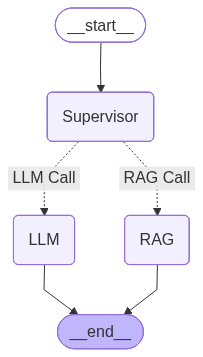

In [35]:
from IPython.display import Image, display

print("\n" + "="*60)
print("📊 VISUALIZING THE AGENT GRAPH...")
print("="*60)

# Display the graph as an image
# This shows how nodes are connected
display(Image(app.get_graph().draw_mermaid_png()))

### STEP 12: RUN THE AGENT (TEST CASES)

In [36]:
print("\n" + "="*80)
print("🚀 RUNNING THE AGENT - TEST CASES")
print("="*80)


🚀 RUNNING THE AGENT - TEST CASES


TEST 1: For General greeting-->> (It should use LLM)

In [37]:
print("\n" + "🧪"*40)
print("TEST 1: General greeting")
print("🧪"*40)

# Create initial state with user's question as HumanMessage
state1 = {"messages": [HumanMessage(content="hi, how are you?")]}

# Run the agent
result1 = app.invoke(state1)

# Extract and display the final answer
print("\n" + "="*60)
print("📋 FINAL ANSWER:")
print("="*60)
final_answer = result1["messages"][-1] # The last message in state is the final answer
print(extract_message_content(final_answer))

# Show the full message history (optional)
print("\n📜 Full message history:")
for i, msg in enumerate(result1["messages"], 1):# Loop through all messages in state and print them
    msg_type = type(msg).__name__  # Get the type of message (e.g., HumanMessage, AIMessage)
    content = extract_message_content(msg)
    print(f"  {i}. [{msg_type}] {content[:80]}...")


🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪
TEST 1: General greeting
🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪

🔍 SUPERVISOR: Classifying the question...
📝 Question: hi, how are you?
✅ Classification: Not Related
💭 Reasoning: The question is a greeting and does not mention the United States or any related topics

🔀 ROUTER: Deciding which path to take...
📋 Classification: Not Related
➡️  Routing to: LLM (General Knowledge)

🤖 LLM: Using general knowledge...
📝 Question: hi, how are you?
✅ Answer (from general knowledge): Hello! I'm just a computer program, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help with any quest...

📋 FINAL ANSWER:
Hello! I'm just a computer program, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help with any questions or tasks you may have. How about you? How's your day going so far?

📜 Full message history:
  1. [HumanMessage] hi, how are you?...
  2. [AIMessage] Not

TEST 2: USA-related question (It should use RAG)

In [38]:
print("\n" + "🧪"*40)
print("TEST 2: USA-related question")
print("🧪"*40)

# Create initial state
state2 = {"messages": [HumanMessage(content="what is the GDP of USA?")]}

# Run the agent
result2 = app.invoke(state2)

# Display final answer
print("\n" + "="*60)
print("📋 FINAL ANSWER:")
print("="*60)
final_answer = result2["messages"][-1]
print(extract_message_content(final_answer))

# Show message history
print("\n📜 Full message history:")
for i, msg in enumerate(result2["messages"], 1):
    msg_type = type(msg).__name__
    content = extract_message_content(msg)
    print(f"  {i}. [{msg_type}] {content[:80]}...")



🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪
TEST 2: USA-related question
🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪

🔍 SUPERVISOR: Classifying the question...
📝 Question: what is the GDP of USA?
✅ Classification: USA
💭 Reasoning: The question asks about US GDP

🔀 ROUTER: Deciding which path to take...
📋 Classification: USA
➡️  Routing to: RAG (Knowledge Base)

📚 RAG: Searching knowledge base...
📝 Question: what is the GDP of USA?
✅ Answer (from documents): The nominal GDP of the USA is estimated to be around $28 trillion USD as of 2024. This accounts for approximately 25% of the global economy. The USA r...

📋 FINAL ANSWER:
The nominal GDP of the USA is estimated to be around $28 trillion USD as of 2024. This accounts for approximately 25% of the global economy. The USA ranks #1 in the world by nominal GDP.

📜 Full message history:
  1. [HumanMessage] what is the GDP of USA?...
  2. [AIMessage] USA...
  3. [AIMessage] The nominal GDP of the USA is estimated to be around $28 trillion USD as

TEST 3: Indirect USA question (It should use RAG)

In [39]:
print("\n" + "🧪"*40)
print("TEST 3: Indirect USA question")
print("🧪"*40)

# Create initial state
state3 = {"messages": [
    HumanMessage(content="tell me about the economy of the world's most powerful country")
]}

# Run the agent
result3 = app.invoke(state3)

# Display final answer
print("\n" + "="*60)
print("📋 FINAL ANSWER:")
print("="*60)
final_answer = result3["messages"][-1]
print(extract_message_content(final_answer))

# Show message history
print("\n📜 Full message history:")
for i, msg in enumerate(result3["messages"], 1):
    msg_type = type(msg).__name__
    content = extract_message_content(msg)
    print(f"  {i}. [{msg_type}] {content[:80]}...")

print("\n" + "="*80)
print("✅ ALL TESTS COMPLETED!")
print("="*80)


🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪
TEST 3: Indirect USA question
🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪🧪

🔍 SUPERVISOR: Classifying the question...
📝 Question: tell me about the economy of the world's most powerful country
✅ Classification: USA
💭 Reasoning: The question refers to the 'world's most powerful country', which is often considered to be the United States, implying the query is about the US economy

🔀 ROUTER: Deciding which path to take...
📋 Classification: USA
➡️  Routing to: RAG (Knowledge Base)

📚 RAG: Searching knowledge base...
📝 Question: tell me about the economy of the world's most powerful country
✅ Answer (from documents): The United States has the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under...

📋 FINAL ANSWER:
The United States has the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed 

### STEP 13: HOW TO USE THIS AGENT

In [40]:

"""
USAGE GUIDE:
------------

1. To ask a question:
   state = {"messages": [HumanMessage(content="Your question here")]}
   result = app.invoke(state)
   answer = result["messages"][-1].content

2. How the agent works:
   User Question → Supervisor (Classify) → Router (Decide) → RAG or LLM → Answer
   
3. When does it use RAG?
   - When question is about USA
   
4. When does it use LLM?
   - When question is NOT about USA
   
5. To add more documents:
   - Put .txt files in the ../data2 folder
   - Restart the script (it will reload documents)

6. To change topics:
   - Modify the TopicSelectionParser class
   - Update the supervisor prompt
   - Update the router logic

7. To debug:
   - Look at the print statements in the console
   - Check the message history in results
   - Visualize the graph
"""

'\nUSAGE GUIDE:\n------------\n\n1. To ask a question:\n   state = {"messages": [HumanMessage(content="Your question here")]}\n   result = app.invoke(state)\n   answer = result["messages"][-1].content\n\n2. How the agent works:\n   User Question → Supervisor (Classify) → Router (Decide) → RAG or LLM → Answer\n\n3. When does it use RAG?\n   - When question is about USA\n\n4. When does it use LLM?\n   - When question is NOT about USA\n\n5. To add more documents:\n   - Put .txt files in the ../data2 folder\n   - Restart the script (it will reload documents)\n\n6. To change topics:\n   - Modify the TopicSelectionParser class\n   - Update the supervisor prompt\n   - Update the router logic\n\n7. To debug:\n   - Look at the print statements in the console\n   - Check the message history in results\n   - Visualize the graph\n'